# 动态系统建模

- 定义自己的 dynamical system
- 模拟 动力系统 并可视化
- 使用block diagram 构建一个简单系统

为了有利于复杂的分析、辨识、估计和控制等任务，Drake可以保持模型的稀疏性和多项式矢量场等结构特性。

Drake 提供了丰富的 动力学系统  
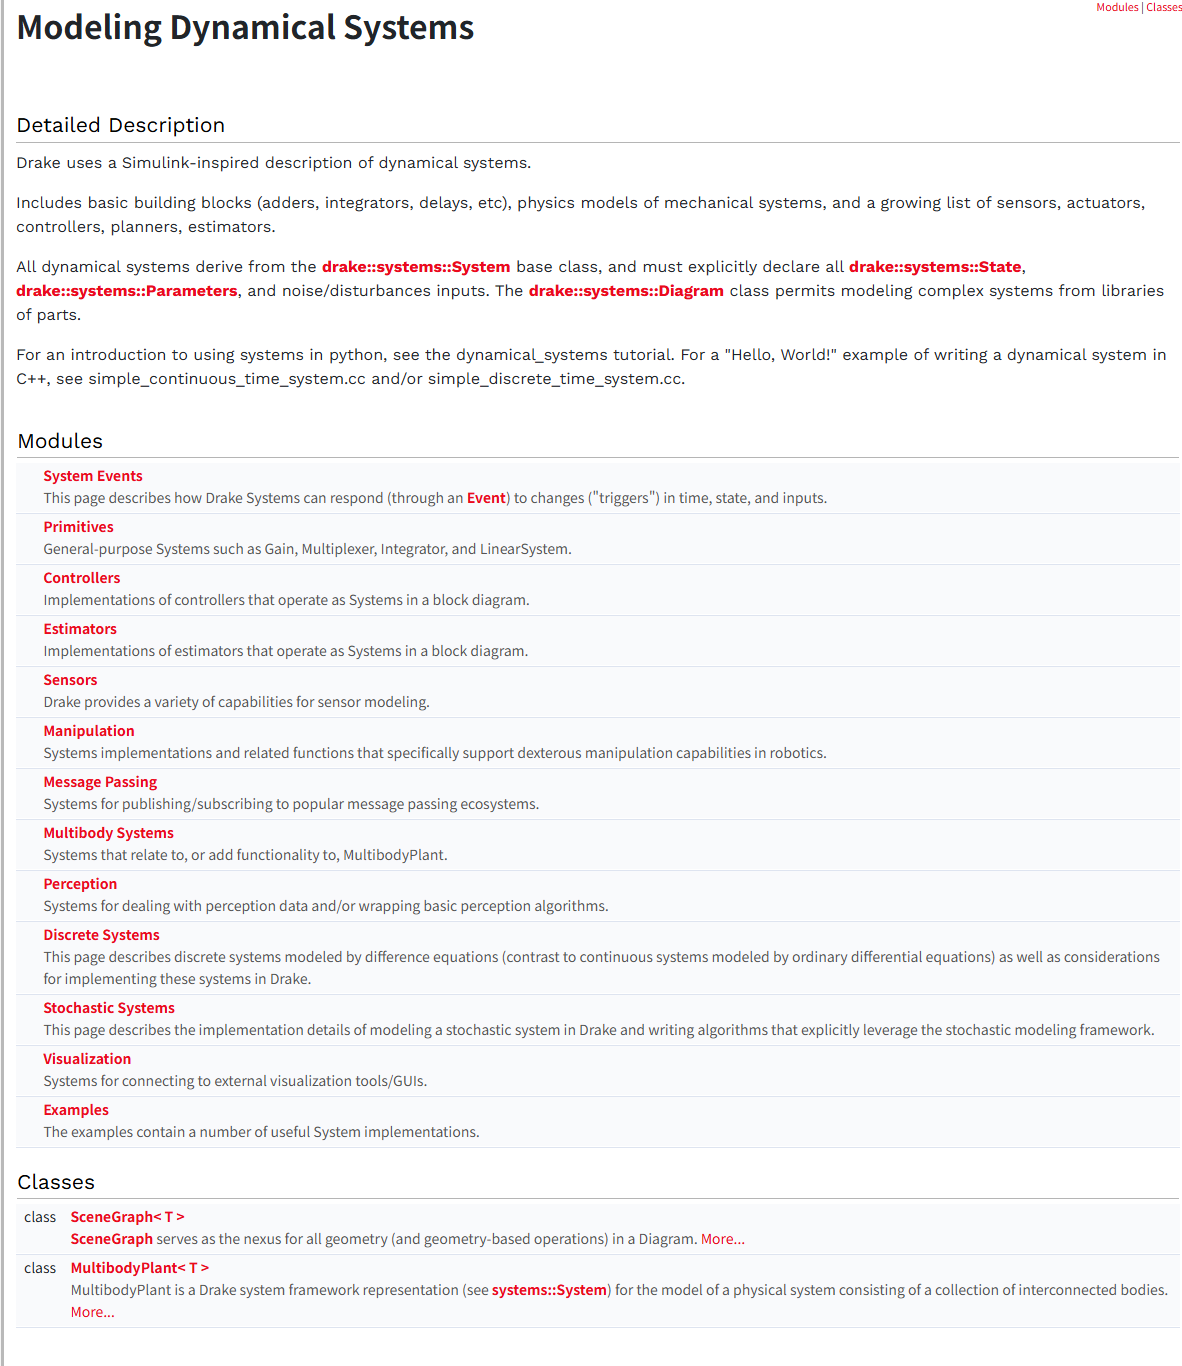

## 自定义 dynamical system


<!-- The following HTML table format was modified from the doxygen System block output, with the goal of matching the style -->
<table align="center" cellpadding="0" cellspacing="0">
<tr align="center">
<td><table cellspacing="0" cellpadding="0">
<tr>
<td align="right" style="padding:5px 0px 5px 0px">u &rarr; </td></tr>
</table>
</td><td align="center" style="border:solid;padding-left:20px;padding-right:20px" bgcolor="#F0F0F0">System</td><td><table cellspacing="0" cellpadding="0">
<tr>
<td align="left" style="padding:5px 0px 5px 0px">&rarr; y </td></tr>
</table>
</td></tr>
</table>

使用 符号向量系统，连续非线性 输出-输出 动力系统：  
$\begin{aligned}\dot{x} =& f(t,x,u), \\ y =& g(t,x,u).\end{aligned}$

其中 \(x\) 是状态向量，\(u\) 是输入向量， \(y\) 是输出向量， \(f\) 和 \(g\) 是 符号向量值函数。  

下面展示一个例子：
$\begin{aligned}\dot{x} =& -x + x^3,\\ y =& x.\end{aligned}$  
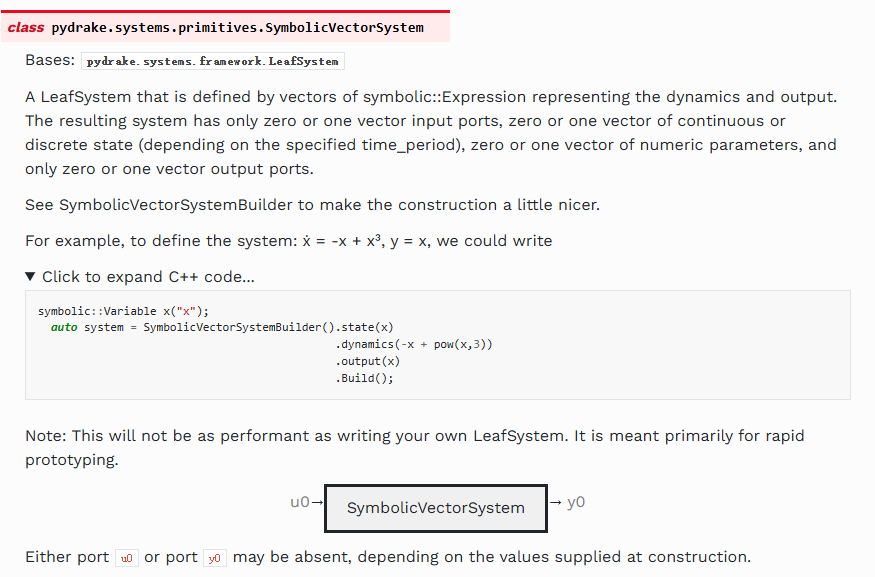

In [14]:
# 导入 pydrake symbolic 和 symbolic vector system
from pydrake.symbolic import Variable
from pydrake.systems.primitives import SymbolicVectorSystem

# 定义 符号变量
x = Variable("x")

# 定义 符号动力系统
continuous_vector_system = SymbolicVectorSystem(state=[x], 
                                                dynamics=[-x + x**3],
                                                output=[x]) 
# 其作为 drake system类的实例，状态表述为一个 symbolic::Variable的向量，动力学和输出表示为 symbolic::Expression 的向量

下面展示离散symbolic vector system:  
$\begin{aligned}
x_{k+1} = f(x_k, u_k), \\ y_k = g(x_k, u_k).
\end{aligned}$

e.g. :  
$\begin{aligned}
x_{k+1} = x^3_k \\ 
y_k = x_k
\end{aligned}$  
这是一个0输入的系统，一个离散状态，一个输出。

In [2]:
from pydrake.symbolic import Variable 
from pydrake.systems.primitives import SymbolicVectorSystem

# 定义 符号变量
x = Variable("x")

# 定义 离散的 符号动力系统
discrete_vector_system = SymbolicVectorSystem(state=[x],
                                            dynamics=[x**3],
                                            output=[x],
                                            time_period=0.1)


## 从 LeafSystem 派生
drake还支持各种类型的系统，如 多输入输出系统、混合离散/连续系统、带有guard和reset的系统、带有约束的系统 和 随机系统。
这些都可以从pydrake.systems.framework.LeafSystem 派生来实现。

使用 LeafSystem 可以：
- 可以不使用 pydrake.symbolic
- 可以重载 LeafSystem 更多方法，来构建更复杂的系统。
- 需要添加几行代码来支持自动微分和符号计算  参考：[Drake 支持自动微分和符号计算的系统模板](https://drake.mit.edu/pydrake/pydrake.systems.scalar_conversion.html#pydrake.systems.scalar_conversion.TemplateSystem)



In [3]:
# 从 framework 导入 LeafSystem
from pydrake.systems.framework import LeafSystem



In [4]:
# 定义系统, 连续非线性动力系统：dot_x = -x + x^3, y = x
class SimpleContinuousSystem(LeafSystem):
    # 初始化，并定义 状态 和 输出
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareContinuousState(1)    # 定义一个连续状态
        self.DeclareStateOutputPort("y", state_index)  # 定义一个输出端口

    # 定义状态的导数
    def DoCalcTimeDerivatives(self, context, derivatives):
    # 其作为 drake system类的子类，必须实现 DoCalcTimeDerivatives 方法来定义状态的导数
        x = context.get_continuous_state_vector().GetAtIndex(0) # 获取状态
        x_dot = -x + x**3                                       # 定义状态导数
        derivatives.get_mutable_vector().SetAtIndex(0, x_dot)   # 设置状态导数, get_mutable_vector() 获取可变的向量

In [5]:
# 定义系统, 离散非线性动力系统：xk+1 = xk^3, yk = xk
class SimpleDiscreteSystem(LeafSystem):
    # 初始化，并定义 状态 和 输出
    def __init__(self):
        LeafSystem.__init__(self)

        state_index = self.DeclareDiscreteState(1)          # 定义一个离散状态，采样时间为0.1s
        self.DeclareStateOutputPort("y", state_index)      # 定义一个输出端口
        self.DeclarePeriodicDiscreteUpdateEvent(
            period_sec=1.0,     # 每1秒更新一次离散状态
            offset_sec=0.0,     # 第一个更新事件在t=0时刻发生
            update=self.Update  # 定义更新函数
        )

    # xk+1 = xk^3
    def Update(self, context, discrete_state):
        x = context.get_discrete_state_vector().GetAtIndex(0)       # 获取离散状态
        x_next = x**3                                               # 定义下一个状态
        discrete_state.get_mutable_vector().SetAtIndex(0, x_next)   # 设置下一个状态

In [15]:
# 实例化系统
continuous_system = SimpleContinuousSystem()
discrete_system = SimpleDiscreteSystem()

# 模拟
通过 pydrake.framework.analysis.Simulator 来模拟 System。此Simulator提供丰富的数值积分方法，包括variable-step变步长积分、stiff solvers刚性求解器和event事件检测。

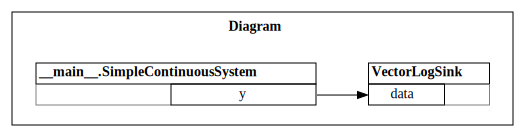

In [16]:
import matplotlib.pyplot as plt
from pydrake.systems.analysis import Simulator # 导入 Simulator
from pydrake.systems.framework import DiagramBuilder # 导入 DiagramBuilder, 用于构建系统
from pydrake.systems.primitives import LogVectorOutput # 导入 LogVectorOutput, 用于记录系统输出

# 使用一个简单的 block diagram 来包含 system
builder = DiagramBuilder() # 实例化 DiagramBuilder
system = builder.AddSystem(SimpleContinuousSystem())            # 添加 SimpleContinuousSystem
logger = LogVectorOutput(system.get_output_port(0), builder)    # 添加 LogVectorOutput, 记录 system 的输出
diagram = builder.Build()                                       # 构建 Diagram

from pydrake.systems.drawing import plot_system_graphviz
plot_system_graphviz(diagram) # 可视化系统

In [8]:
# 设置 初始状态 x0 = 0.9
context = diagram.CreateDefaultContext()
context.SetContinuousState([0.9])

# 创建模拟器，并且模拟 10 秒
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10.0)


Text(0, 0.5, 'output y')

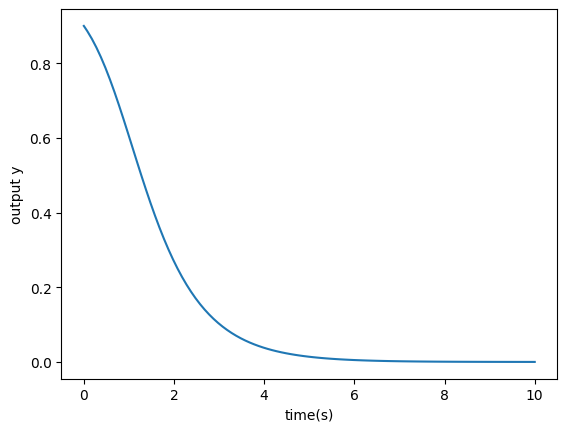

In [9]:
log = logger.FindLog(context) # 获取日志

# 绘制结果
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('time(s)')
plt.ylabel('output y')

Text(0, 0.5, 'output y')

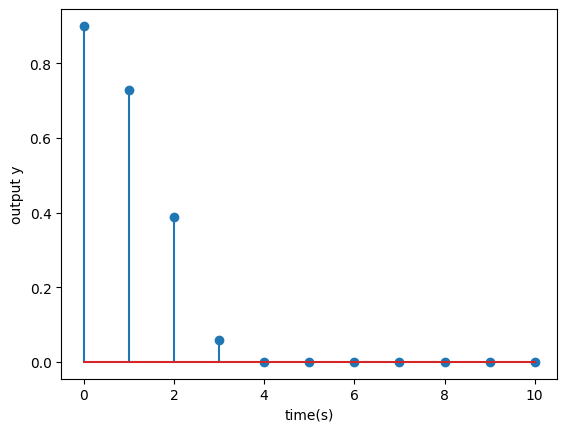

In [10]:
# 离散系统的模拟与连续系统类似，只需将 SimpleContinuousSystem 替换为 SimpleDiscreteSystem，并设置离散状态的初始值即可。
builder = DiagramBuilder() # 实例化 DiagramBuilder
system = builder.AddSystem(SimpleDiscreteSystem())            # 添加 SimpleContinuousSystem
logger = LogVectorOutput(system.get_output_port(0), builder)    # 添加 LogVectorOutput, 记录 system 的输出
diagram = builder.Build()   

# 创建模拟器
simulator = Simulator(diagram)

# 初始化离散状态 x0 = 0.9
state = simulator.get_mutable_context().get_mutable_discrete_state_vector() # 获取离散状态
state.SetFromVector([0.9])

simulator.AdvanceTo(10)

log = logger.FindLog(simulator.get_context()) # 获取日志
plt.figure()
plt.stem(log.sample_times(), log.data().transpose()) # 绘制离散数据
plt.xlabel('time(s)')
plt.ylabel('output y')

对于许多系统来说，模拟运行速度会比实时运行速度快得多。如果您想让模拟器（如果可能）减慢到实时时钟的某个倍数，可以考虑使用set_target_realtime_rate()的方法Simulator。例如，如果您尝试在机器人模拟时为其制作动画，并希望获得物理直觉的帮助，或者尝试将模拟用作多进程实时控制系统的一部分，这种方法就非常有用。

# Context
在 Darke 中，context 捕获了一个系统的所有动态信息，包括时间、状态、输入和任何系统参数。给定 context，系统上的任何方法都是可复现的。

上面代码中，Simulator 创建了一个 Context，我们从Simulator中取出这个 Context，并设置了初始状态。

在所有输入端口都已连接的情况下，context 才是完整的，否则模拟将会失败。

# 系统组合—— Block Diagram
Drake 真正的建模能力在于将许多较小的系统组合成更复杂的系统。

其概念非常简单：我们使用DiagramBuilder类来AddSystem()连接Connect()输入端口和输出端口，或者将它们公开为图的输入/输出。

然后我们调用Build()来生成新的Diagram实例，该实例只是System框架中的另一个实例，可以使用整套工具进行模拟或分析。

在下面的示例中，我们连接三个子系统（一个plant、一个constroller和一个logger），并将控制器的输入作为Diagram正在构建的输入公开：

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pydot
from pydrake.examples import PendulumPlant # 导入摆系统
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import PidController # 导入 PID 控制器
from pydrake.systems.drawing import plot_system_graphviz # 导入 plot_system_graphviz, 用于绘制系统图
from pydrake.systems.framework import DiagramBuilder 
from pydrake.systems.primitives import LogVectorOutput


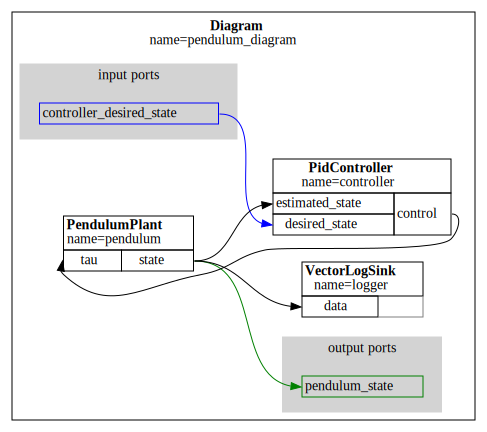

In [12]:
builder = DiagramBuilder() # 实例化 DiagramBuilder

pendulum = builder.AddNamedSystem("pendulum", PendulumPlant()) # 添加摆系统
controller = builder.AddNamedSystem("controller", 
                                    PidController(kp=[10.], ki=[1.], kd=[1.])) # 添加 PID 控制器

# 将其controller 连接到 plant上
builder.Connect(pendulum.get_output_port(),                     # 将摆系统的输出连接到控制器的输入
                controller.get_input_port_estimated_state())        # 控制器的输入是对状态的估计
builder.Connect(controller.get_output_port_control(), pendulum.get_input_port()) # 将控制器的输出连接到摆系统的输入

# 将控制器的输入作为 Diagram 的输入
builder.ExportInput(controller.get_input_port_desired_state())

# 将pendulum的输出作为 Diagram 的输出
builder.ExportOutput(pendulum.get_output_port())

# 记录pendulum输出
logger = LogVectorOutput(pendulum.get_output_port(), builder)
logger.set_name("logger")

# 构建 Diagram
diagram = builder.Build()
diagram.set_name("pendulum_diagram")

# 可视化 diagram
plot_system_graphviz(diagram)

diagram与system相似，也具有context，可以使用Diagram.GetSubSystemContext()来访问子系统的context，或者使用Diagram.GetMutableSubsystemContext()来修改子系统的context。  


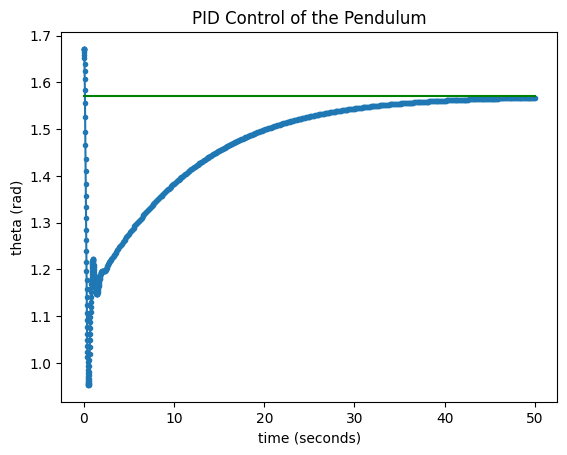

In [ ]:
# 使用simulator 进行模拟 diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context() # 获取 diagram 的 context

# 设置 期望位置为 pi/2
desired_angle = np.pi / 2

# 从 pendulum 中提取子系统的 context，并设置状态[\theta, \dot{\theta}]
pendulum_context = diagram.GetMutableSubsystemContext(pendulum, context)
pendulum_context.get_mutable_continuous_state_vector().SetFromVector([desired_angle+0.1, 0.2]) # 初始状态为：[期望位置+0.1, 0.2]

# 设置 diagram 的输入，即 controller 的期望位置, port index = 0
diagram.get_input_port(0).FixValue(context, [desired_angle, 0.])

# 清空日志
logger.FindMutableLog(context).Clear()

# 模拟 50 秒
simulator.AdvanceTo(50.0)

# 绘制结果
log = logger.FindLog(simulator.get_context())
t = log.sample_times()
plt.figure()
# Plot theta.
plt.plot(t, log.data()[0,:],'.-')
# Draw a line for the desired angle.
plt.plot([t[0], t[-1]], [desired_angle, desired_angle], 'g' )
plt.xlabel('time (seconds)')
plt.ylabel('theta (rad)')
plt.title('PID Control of the Pendulum');

在这个教程中，我们学习了：
1. **定义动力系统**: 使用 `SymbolicVectorSystem` 和继承 `LeafSystem` 两种方法
2. **系统仿真**: 使用 `Simulator` 进行数值积分仿真
3. **系统组合**: 使用 `DiagramBuilder` 构建复杂的控制系统


System 是 Drake 系统框架的基类，代表任何动力学系统的抽象接口。

- LeafSystem 是 System 的子类，表示“叶子”系统，即不可再分的基本系统。你可以通过继承 LeafSystem 来自定义自己的动力学系统，实现具体的动力学、输出等方法。
- Diagram 也是 System 的子类，但它是“组合系统”，可以包含多个子系统（包括 LeafSystem 或其他 Diagram），用于系统组合和层次化建模。